In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [2]:
# Step 1: Data Loading and Exploration

data_dir = "lung_colon_image_set"  # Replace with the actual path to the dataset
lung_dir = os.path.join(data_dir, "lung_image_sets")
colon_dir = os.path.join(data_dir, "colon_image_sets")
lung_categories = ["lung_n", "lung_aca", "lung_scc"]
colon_categories = ["colon_aca", "colon_n"]

image_data = []
labels = []

def load_data():
    for category_idx, category in enumerate(lung_categories):
        path = os.path.join(lung_dir, category)
        for img_name in os.listdir(path):
            try:
                img_path = os.path.join(path, img_name)
                image = cv2.imread(img_path)
                image = cv2.resize(image, (224, 224))  # Resize to match model input size (e.g., 224x224)
                image_data.append(image)
                labels.append(category_idx)
            except Exception as e:
                print(f"Error loading image: {img_path}, error: {e}")
    
    for category_idx, category in enumerate(colon_categories, start=len(lung_categories)):
        path = os.path.join(colon_dir, category)
        for img_name in os.listdir(path):
            try:
                img_path = os.path.join(path, img_name)
                image = cv2.imread(img_path)
                image = cv2.resize(image, (224, 224))  # Resize to match model input size (e.g., 224x224)
                image_data.append(image)
                labels.append(category_idx)
            except Exception as e:
                print(f"Error loading image: {img_path}, error: {e}")

load_data()

# Convert lists to numpy arrays
image_data = np.array(image_data, dtype='float32') / 255.0  # Normalizing the images
labels = np.array(labels)

Category lung_n: 5000 images
Category lung_aca: 5000 images
Category lung_scc: 5000 images
Category colon_aca: 5000 images
Category colon_n: 5000 images


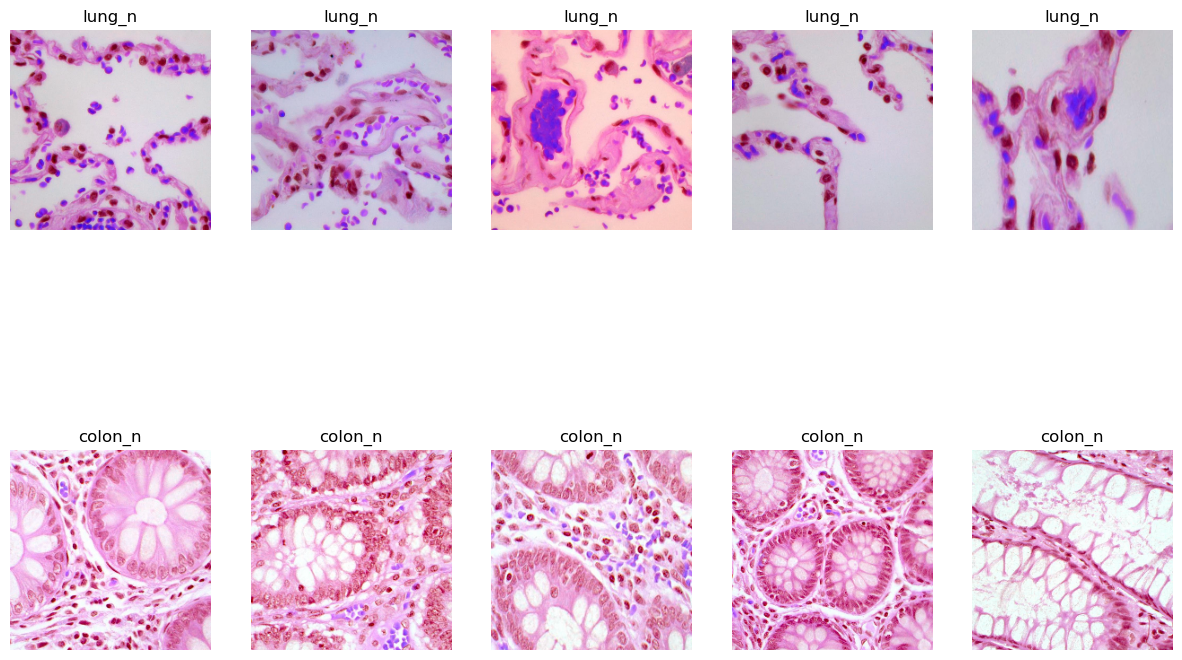

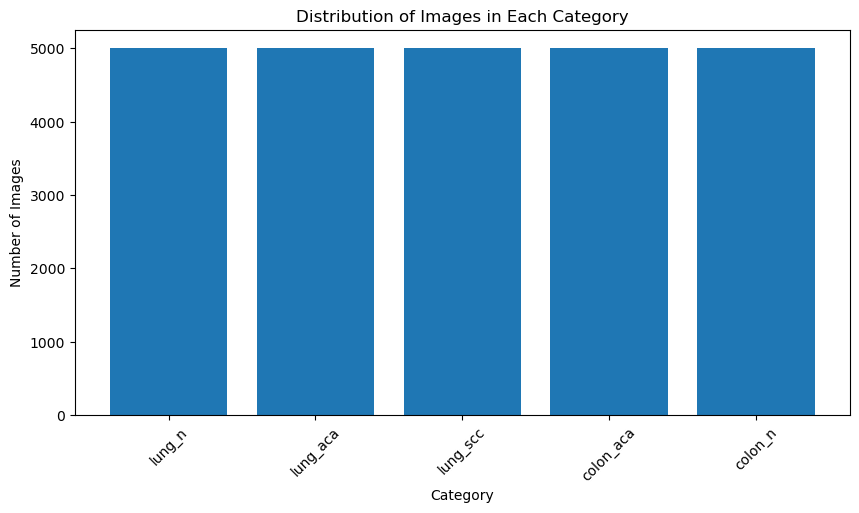

Shape of image_data: (25000, 224, 224, 3)
Shape of labels: (25000,)
Sample image pixel values (first image):
[[[0.827451   0.5058824  0.70980394]
  [0.7764706  0.42352942 0.67058825]
  [0.7882353  0.40392157 0.69411767]
  ...
  [0.8156863  0.8235294  0.827451  ]
  [0.8156863  0.8235294  0.827451  ]
  [0.8117647  0.81960785 0.8235294 ]]

 [[0.8392157  0.5254902  0.7490196 ]
  [0.78039217 0.43529412 0.6901961 ]
  [0.76862746 0.38431373 0.6862745 ]
  ...
  [0.8039216  0.8117647  0.8156863 ]
  [0.8039216  0.8117647  0.8156863 ]
  [0.8        0.80784315 0.8117647 ]]

 [[0.827451   0.54509807 0.77254903]
  [0.8039216  0.48235294 0.73333335]
  [0.7607843  0.4        0.6784314 ]
  ...
  [0.8039216  0.8117647  0.8156863 ]
  [0.8        0.80784315 0.8117647 ]
  [0.80784315 0.8156863  0.81960785]]

 ...

 [[0.8039216  0.7921569  0.8       ]
  [0.8117647  0.8        0.80784315]
  [0.80784315 0.79607844 0.8039216 ]
  ...
  [0.5176471  0.1254902  0.36078432]
  [0.7254902  0.36078432 0.7058824 ]
  [0

In [3]:
# Step 2: Exploratory Data Analysis (EDA)

# Display the number of images in each category
category_counts = pd.Series(labels).value_counts()
categories = lung_categories + colon_categories
for idx, count in category_counts.items():
    print(f"Category {categories[idx]}: {count} images")

# Display a few sample images from each category
plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image_data[i])
    plt.title(categories[labels[i]])
    plt.axis('off')

for i in range(5):
    plt.subplot(2, 5, i + 6)
    plt.imshow(image_data[-(i + 1)])
    plt.title(categories[labels[-(i + 1)]])
    plt.axis('off')
plt.show()

# Plot the distribution of image classes
plt.figure(figsize=(10, 5))
plt.bar(categories, category_counts)
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Distribution of Images in Each Category')
plt.xticks(rotation=45)
plt.show()

# Check the shape of the dataset and a few example pixel values
print(f"Shape of image_data: {image_data.shape}")
print(f"Shape of labels: {labels.shape}")
print(f"Sample image pixel values (first image):\n{image_data[0]}")

In [9]:
# Step 3: Splitting Dataset

sample_size = 10000
X_sample = image_data[:sample_size]
y_sample = labels[:sample_size]

X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [28]:
# Step 4: Data Augmentation

datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [29]:
# Step 5: Model Building

from tensorflow.keras.regularizers import l2

def build_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))
    return model


In [30]:
# Step 6: Model Compilation

from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-5, clipvalue=1.0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Step 7: Model Training

batch_size = 64
epochs = 25

# Adding Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    callbacks=[early_stopping]
)


Epoch 1/25
112/112 ━━━━━━━━━━━━━━━━━━━━ 76s 667ms/step - accuracy: 0.9990 - loss: 0.0039 - val_accuracy: 0.9987 - val_loss: 0.0030
Epoch 2/25
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 1.0000 - loss: 7.9908e-04 - val_accuracy: 0.9987 - val_loss: 0.0030
Epoch 3/25
112/112 ━━━━━━━━━━━━━━━━━━━━ 76s 672ms/step - accuracy: 0.9972 - loss: 0.0067 - val_accuracy: 0.9987 - val_loss: 0.0032
Epoch 4/25
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 1.0000 - loss: 0.0092 - val_accuracy: 0.9987 - val_loss: 0.0032
Epoch 5/25
112/112 ━━━━━━━━━━━━━━━━━━━━ 76s 675ms/step - accuracy: 0.9985 - loss: 0.0058 - val_accuracy: 0.9987 - val_loss: 0.0026
Epoch 6/25
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 1.0000 - loss: 2.8501e-04 - val_accuracy: 0.9987 - val_loss: 0.0026
Epoch 7/25
112/112 ━━━━━━━━━━━━━━━━━━━━ 74s 654ms/step - accuracy: 0.9971 - loss: 0.0098 - val_accuracy: 0.9987 - val_loss: 0.0023
Epoch 8/25
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 1.0000 - loss: 0

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.9982 - loss: 0.0019
Test Accuracy: 1.00


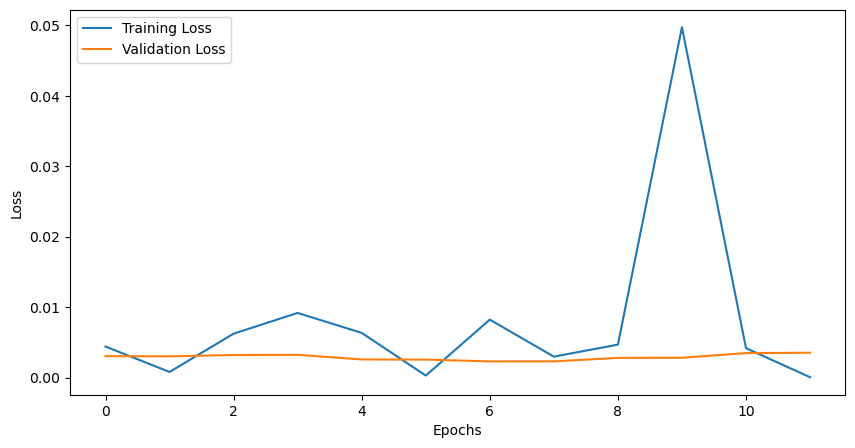

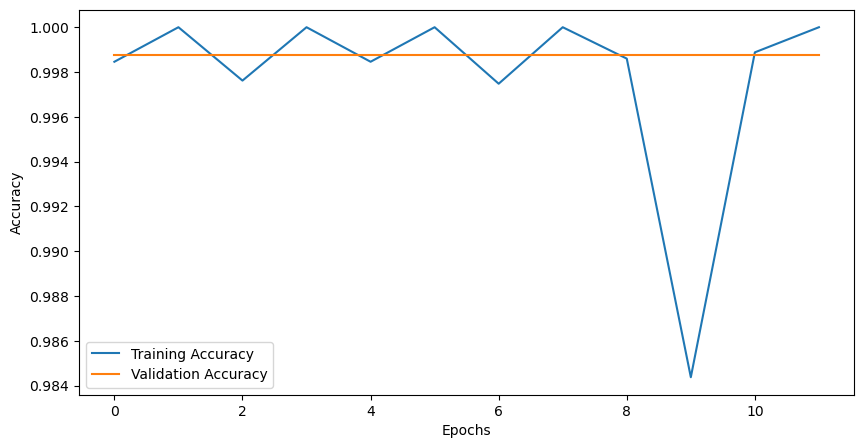

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step


<Figure size 1000x800 with 0 Axes>

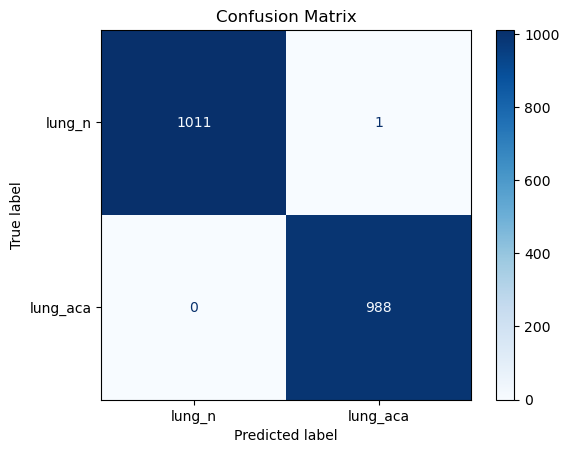

Classification Report:
              precision    recall  f1-score   support

      lung_n       1.00      1.00      1.00      1012
    lung_aca       1.00      1.00      1.00       988

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



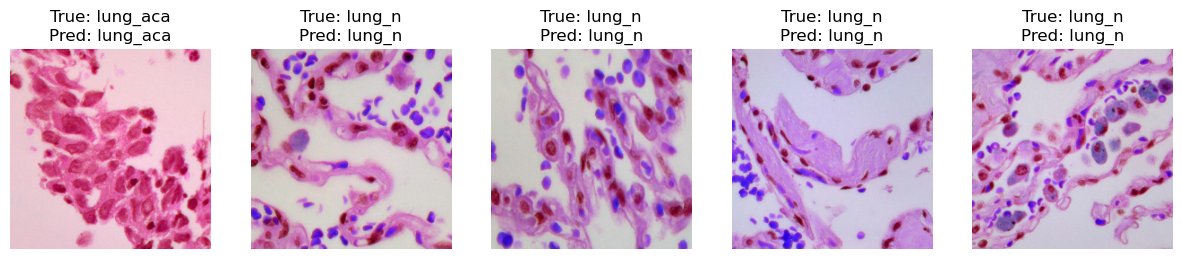

In [34]:
# Step 8: Model Evaluation

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Step 9: Visualization

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot learning rate over epochs (if learning rate scheduler is used)
if 'lr' in history.history:
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['lr'], label='Learning Rate')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.show()

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
disp = unique_labels = np.unique(y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[categories[i] for i in unique_labels])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=[categories[i] for i in unique_labels]))

# Plot sample predictions
plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[i])
    plt.title(f"True: {categories[y_test[i]]}\nPred: {categories[y_pred_classes[i]]}")
    plt.axis('off')
plt.show()

# Step 10: Save the Model
model.save('histopathology_classification_model.h5')